In [229]:
import re
import random
import pandas as pd
import hashlib

In [230]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.5) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [231]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
DAX,18.675431,2.075048,4.063526,9
Email Auth and Security,195.912899,48.978225,71.028641,4
Azure VM + Developer,270.674157,7.961005,16.536698,34
"Jane Eyre, Bronte",323.269445,40.408681,59.752775,8
TSQL,578.893662,24.120569,31.261592,24
Azure AD Authentication,781.485602,65.123800,141.914544,12
RAG Project,818.534431,90.948270,242.236467,9
Logging in Python,893.682041,63.834432,104.846147,14
Azure Private DNS,1460.446537,76.865607,150.678344,19
Azure Functions + PP365,1974.082981,94.003951,217.781886,21


# Histogram

sum of ages: ~47606.69


<Axes: >

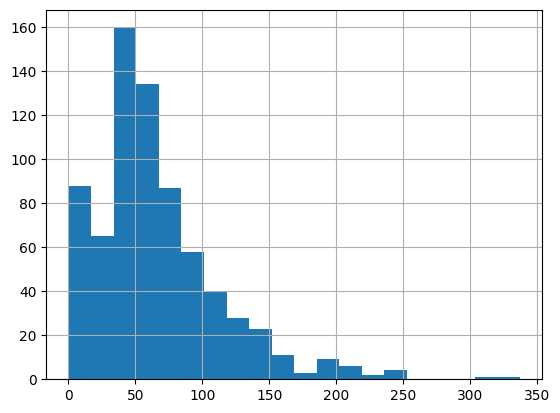

In [232]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~-47606.69


<Axes: >

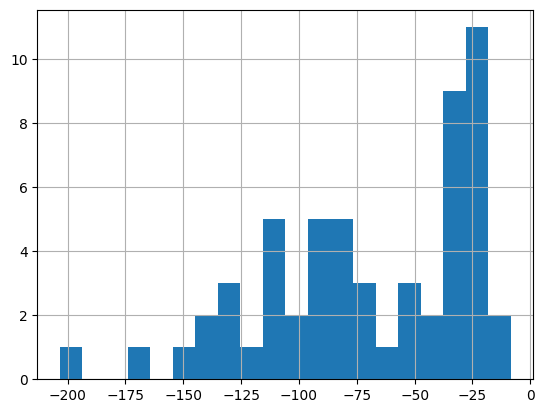

In [250]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Azure Developer Associate']['age'].hist(bins=20)

# Completely Random Shuffle

In [234]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [235]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [236]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [237]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [238]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [239]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [240]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [241]:
# n=3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [242]:
n=3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 720
Total card age: 47606.69


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
57,PowerShell Modules,Module Scope Management\n\nDefinition: Control...,2ebf820a231a01c49801fca43af0a504,-336.735601,-98.671501,336.735601,3650.84552,0.226064,0,0
58,PowerShell Modules,Get-Module\n\nDefinition: A cmdlet that retrie...,0d76065f3213ee411ee6f7e377583cc9,-193.185239,-98.671501,336.735601,3650.84552,0.226064,3,0
546,PowerShell Modules,Import-Module\n\nDefinition: A cmdlet used to ...,948f849b76379a9f1383f41ea47c2668,-127.506556,-98.671501,336.735601,3650.84552,0.226064,6,0
60,PowerShell Modules,Get-Command -Module <ModuleName>\n\nDefinition...,2cac5915c1ac83670ce3862d65087a98,-113.203413,-98.671501,336.735601,3650.84552,0.226064,9,0
548,PowerShell Modules,Module Path\n\nDefinition: The directories whe...,0ed10fbc284c0a9a7c52e763081c5d43,-103.555835,-98.671501,336.735601,3650.84552,0.226064,12,0
549,PowerShell Modules,Connect-AzAccount\n\nDefinition: A cmdlet from...,7faeb939687d0f52394878bd6570d313,-92.883505,-98.671501,336.735601,3650.84552,0.226064,15,0
550,PowerShell Modules,Exporting Functions and Cmdlets\nDefinition: T...,bd35c9936ab6714ca8f150b76830fc98,-82.243728,-98.671501,336.735601,3650.84552,0.226064,18,0
312,PowerShell Modules,Az Module\n\nDefinition: A module for managing...,49771a588dddc1647bb2c56ec18094e7,-74.702741,-98.671501,336.735601,3650.84552,0.226064,21,0
313,PowerShell Modules,Module Version Specification\n\nDefinition: Th...,d4ec6075777ae434d0d1401abae8cdfd,-68.214784,-98.671501,336.735601,3650.84552,0.226064,24,0
66,PowerShell Modules,Installing a Module:\nInstall-Module -Name Az ...,1157ddac72e8cb45710b8745a0b04bda,-60.276277,-98.671501,336.735601,3650.84552,0.226064,27,0


## Age Max

In [243]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [244]:
# n=5
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [245]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [246]:
existing_cards.sort_values('age', ascending=False).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
342,JavaScript Concepts,Callback\nA function passed as an argument to ...,9b3cd917f72d441abfeee7a79c32a076,-0.350928,-45.453376,240.783275,3681.723477,0.713347,80,2
243,DAX,"KEEPFILTERS is a modifier, not a standalone fu...",7a0281de21010d4d00b478be91e8278f,-0.443157,-2.075048,4.063526,18.675431,0.554693,8,2
95,JavaScript Concepts,If the addition operator + is used for primiti...,9cb500afa3eac8e680fbc3cd173ada6b,-0.459898,-45.453376,240.783275,3681.723477,0.713347,79,1
343,JavaScript Concepts,"In JavaScript, you can only return exactly one...",ff371a8725914a03ceed40564889f505,-0.490847,-45.453376,240.783275,3681.723477,0.713347,78,0
340,JavaScript Concepts,Using Object.keys() with for...of Loop: The Ob...,06c15a040f743007e381b243ccc3d915,-0.506309,-45.453376,240.783275,3681.723477,0.713347,77,2
582,JavaScript Concepts,JavaScript's array destructuring syntax is a c...,d1873d9f239196132e5ff5341adb3922,-0.516202,-45.453376,240.783275,3681.723477,0.713347,76,1
718,DAX,KEEPFILTERS returns BLANK when there’s no over...,0d2982279e67596cd2d608571195576d,-0.660089,-2.075048,4.063526,18.675431,0.554693,7,1
483,DAX,KEEPFILTERS vs. ALL/REMOVEFILTERS (and other m...,5d7a1a933dccd50da553422291e161c0,-0.690787,-2.075048,4.063526,18.675431,0.554693,6,0
580,JavaScript Concepts,When ... appears on the right-hand side of an ...,10bddd23b38f376d792526c3e14f9065,-0.777964,-45.453376,240.783275,3681.723477,0.713347,75,0
91,JavaScript Concepts,Front: How do you create multiline strings usi...,0576807b2b6955c94c9c49ed2cf9a6b8,-1.000163,-45.453376,240.783275,3681.723477,0.713347,74,2


In [247]:
existing_cards.head(10).sum()

head                   PowerShell ModulesPowerShell ModulesPowerShell...
body                   Module Scope Management\n\nDefinition: Control...
hash                   2ebf820a231a01c49801fca43af0a5040d76065f3213ee...
age                                                         -1252.507678
subject_mean_age                                             -986.715005
subject_highest_age                                          3367.356005
subject_age_sum                                             36508.455201
head_random_roll                                                2.260637
count                                                                135
n_fold                                                                 0
dtype: object

In [248]:
existing_cards['age'].mean()

-66.12040435482135